In [87]:
%matplotlib inline

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt

CDI = 14.15

#### 1. Coletando dados

Vamos trabalhar com apenas uma ação para simplificar o problema. Buscando 10 anos de dados

In [88]:
tickers = ['ITUB4.SA']

start_date = '2025-01-01'
end_date =  '2025-11-01'

for ticker in tickers:
    prices = yf.download(ticker, start=start_date, end=end_date, interval='1d', auto_adjust=True)
    data = prices.droplevel(1, axis=1)
    df = data.dropna()

    # Salvando o CSV
    df.to_csv(f'../data/raw/backtest_{ticker}_data.csv')

[*********************100%***********************]  1 of 1 completed


Pontos importantes:

- Será feito usando até 2023 por causa da separação do OOS e da normalização dos dados. O correto é ir retreinando o scaler e o modelo periodicamente
- Será usado IBOV para minimizar o efeito de look ahead bias dos proventos

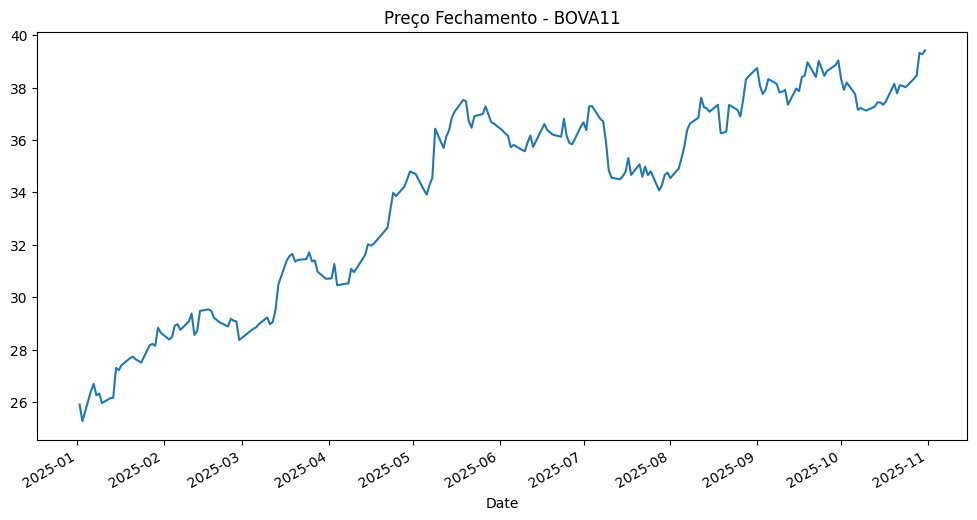

In [89]:
df.Close.plot(title='Preço Fechamento - BOVA11', figsize=(12,6));

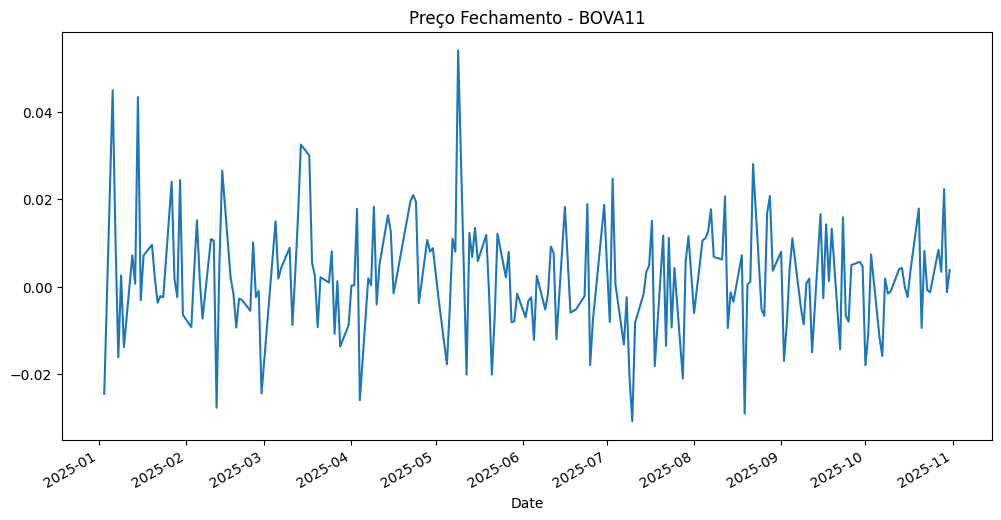

In [90]:
df.Close.pct_change().dropna().plot(title='Preço Fechamento - BOVA11', figsize=(12,6))
plt.show()

In [91]:
class CarryBroker(bt.brokers.BackBroker):
    params = dict(carry=CDI/100)

    def __init__(self):
        super().__init__()

    def next(self):
        daily_carry = (1 + self.p.carry) ** (1/252) - 1
        self.cash += self.cash * daily_carry        
        super().next()

class TorchModel(bt.Strategy):

    params = dict(
        period=2,    # RSI lookback period
        lb=5,        # lower bound
    )

    def __init__(self, agent, agent_path='', config=None):
        self.agent = agent
        self.agent.epsilon = 0.0  # No exploration during testing
        self.hidden = agent.init_hidden()
        self.config = config

        self.rsi = bt.indicators.RSI(self.data.close, period=self.p.period)

        self.entry_price = 0.0
        self.entry_idx = -1 
        self.lookback = 15
        self.max_steps = 20 # len(self.data) - 1  # total steps in the episode

        if agent_path:
            self.agent.load(agent_path)

    def _get_state(self, data):
        """
        State representation (Paper-aligned):
        - 15 recent prices (normalized by entry_price)
        - Current PnL %
        - Time remaining (normalized)
        - Current RSI (normalized)
        - Recent volatility
        """
        
        # Prices (last 15 days)
        prices = np.array([self.data.close[-i] for i in range(self.lookback-1, -1, -1)])
        
        idx = 0 # we are always at the end of the data in backtrader
        
        # Ensure prices is 1D array
        if len(prices.shape) > 1:
            prices = prices.flatten()
        
        normalized_prices = np.zeros(self.lookback, dtype=np.float32)
        
        if len(prices) > 0:
            # Normalize by entry price
            # P_t / P_entry
            norm_p = prices / self.entry_price
            
            # Take last lookback prices
            n_prices = min(len(norm_p), self.lookback)
            if n_prices > 0:
                normalized_prices[-n_prices:] = norm_p[-n_prices:]
        
        # Current PnL %
        current_price = float(data.close[idx])
        pnl_pct = (current_price - self.entry_price) / self.entry_price
        
        # Time remaining (normalized)
        # T - t
        time_remaining = (self.max_steps - (len(self.data) - self.entry_idx)) / self.max_steps
        
        # RSI (normalized to 0-1)
        rsi = float(self.rsi[idx]) / 100.0
        
        # Volatility (std of last 15 returns)
        # We still calculate returns for volatility as it's a good feature
        returns = np.diff(prices) / prices[:-1] if len(prices) > 1 else []
        volatility = float(np.std(returns)) if len(returns) > 0 else 0.0
                
        state = np.concatenate([
            normalized_prices,
            np.array([pnl_pct, time_remaining, rsi, volatility], dtype=np.float32)
        ])
        
        return state

    def next(self):

        if self.rsi[0] < self.p.lb and not self.position:
            size = self.broker.getcash() // self.data.close[0]
            self.buy(size=size)  # market order on next bar
            self.entry_price = float(self.data.close[0])
            self.entry_idx = len(self.data)
            return

        if len(self.data) < self.lookback:
            return
        
        if self.position:
            if len(self.data) > self.entry_idx + self.max_steps:
                self.sell(size=self.position.size)  # market order on next bar
                return

            state = self._get_state(self.data)
        
            action, self.hidden = self.agent.select_action(state, self.hidden, training=False)

            if action == 1:  # Sell
                self.sell(size=self.position.size)  # market order on next bar

In [92]:
def simulate_strategy_ml(strategy, agent, agent_path, config):
    cerebro = bt.Cerebro(stdstats=True) # Create Engine Simulation
    cerebro.broker = CarryBroker(carry=CDI/100)

    df = pd.read_csv(f'../data/raw/backtest_{tickers[0]}_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.dropna()

    cerebro.adddata(bt.feeds.PandasData(dataname=df), name=ticker) # Add data
    
    cerebro.addstrategy(strategy, agent=agent, agent_path=agent_path, config=config)

    CUSTO_EMOLUMENTOS = (0.005 + 0.0275)/100   # taxa de 0.005% + 0.0275% (emolumentos)    

    # Adjusting portfolio parameters
    cerebro.broker.setcash(1_000_000)
    cerebro.broker.setcommission(commission=CUSTO_EMOLUMENTOS)
    cerebro.broker.set_coc(True)  # cheat on close - do it in the same day

    # Performance & Risk Metrics
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, _name='timereturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=CDI/100, factor=252, annualize=True, timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Calmar, _name='calmar')

    # Trade
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
    cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
    cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions')

    # Run the strategy
    results = cerebro.run()
    strat = results[0]

    # Extract and display all performance metrics
    print("=" * 60)
    print("PERFORMANCE METRICS SUMMARY")
    print("=" * 60)

    # Basic Returns
    returns_analyzer = strat.analyzers.returns.get_analysis()
    print(f"Total Return: {returns_analyzer['rtot']:.2%}")
    print(f"Average Return: {returns_analyzer['ravg']:.4%}")
    print(f"Compound Annual Growth Rate: {returns_analyzer['rnorm100']:.2%}")

    # Sharpe Ratio
    sharpe = strat.analyzers.sharpe.get_analysis()
    print(f"Sharpe Ratio: {sharpe.get('sharperatio', 'N/A'):.4f}" if sharpe.get('sharperatio') else "Sharpe Ratio: N/A")

    # DrawDown Analysis
    dd = strat.analyzers.drawdown.get_analysis()
    print(f"Max Drawdown: {dd.max.drawdown:.2%}")
    print(f"Max Drawdown Duration: {dd.max.len} periods")
    print(f"Max Drawdown Money: ${dd.max.moneydown:,.2f}")

    # Trade Analysis
    trade_analysis = strat.analyzers.trade_analyzer.get_analysis()
    total_trades = trade_analysis.total.get('total', 0)
    print(f"Total Trades: {total_trades}")
    
    if total_trades > 0:
        print(f"Total Open Trades: {trade_analysis.total.get('open', 0)}")
        print(f"Total Closed Trades: {trade_analysis.total.get('closed', 0)}")
        
        print(f"\nWinning Trades: {trade_analysis.won.get('total', 0)}")
        print(f"Losing Trades: {trade_analysis.lost.get('total', 0)}")
        print(f"Win Rate: {(trade_analysis.won.get('total', 0) / total_trades) * 100:.1f}%")
        
        if trade_analysis.won.get('total', 0) > 0:
            print(f"Average Win: ${trade_analysis.won.pnl.get('average', 0):,.2f}")
            print(f"Max Win: ${trade_analysis.won.pnl.get('max', 0):,.2f}")
        
        if trade_analysis.lost.get('total', 0) > 0:
            print(f"Average Loss: ${trade_analysis.lost.pnl.get('average', 0):,.2f}")
            print(f"Max Loss: ${trade_analysis.lost.pnl.get('max', 0):,.2f}")
        
        print(f"Average Trade: ${trade_analysis.pnl.get('net', {}).get('average', 0):,.2f}")
        print(f"Average Trade Length: {trade_analysis.len.get('average', 0):.1f} periods")
        
        # Profit Factor
        gross_profit = trade_analysis.won.pnl.get('total', 0)
        gross_loss = abs(trade_analysis.lost.pnl.get('total', 0))
        if gross_loss > 0:
            profit_factor = gross_profit / gross_loss
            print(f"Profit Factor: {profit_factor:.2f}")

    print(f"Final Portfolio Value: ${cerebro.broker.getvalue():,.2f}")

    figs = cerebro.plot(iplot=False)
    plt.show()


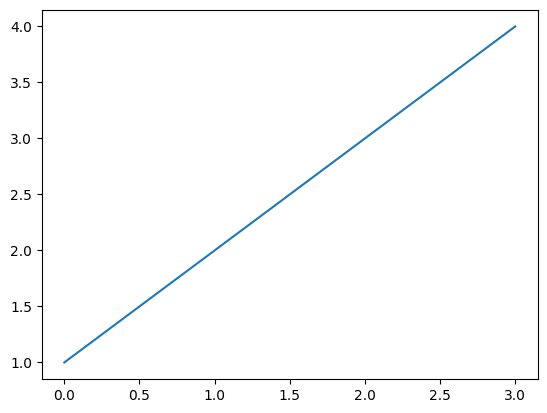

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
# Test plot
plt.plot([1, 2, 3, 4])
plt.show()



Loading RL agent...
Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✓ Model loaded from ../checkpoints/checkpoint_epoch_5.pth
PERFORMANCE METRICS SUMMARY
Total Return: 12.05%
Average Return: 0.0571%
Compound Annual Growth Rate: 1547.84%
Sharpe Ratio: 0.3708
Max Drawdown: 143.82%
Max Drawdown Duration: 49 periods
Max Drawdown Money: $15,743.26
Total Trades: 3
Total Open Trades: 0
Total Closed Trades: 3

Winning Trades: 1
Losing Trades: 2
Win Rate: 33.3%
Average Win: $41,198.56
Max Win: $41,198.56
Average Loss: $-12,788.25
Max Loss: $-14,009.42
Average Trade: $5,207.36
Average Trade Length: 4.0 periods
Profit Factor: 1.61
Final Portfolio Value: $1,128,059.63


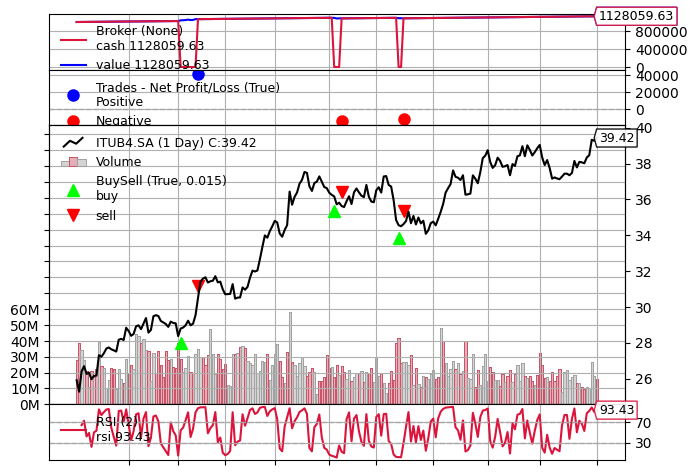

In [94]:
from agent import DDQNAgent
import yaml


# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load RL agent
print("\nLoading RL agent...")
agent = DDQNAgent(state_size=19, action_size=2, config=config)

simulate_strategy_ml(TorchModel, agent, agent_path="../checkpoints/checkpoint_epoch_5.pth", config=config)

In [95]:
class RSIMeanReversion(bt.Strategy):
    params = dict(
        period=2,    # RSI lookback period
        lb=5,        # lower bound
        ub=80,       # upper bound
    )

    def __init__(self):
        # Create RSI indicator
        self.rsi = bt.indicators.RSI(self.data.close, period=self.p.period)

    def next(self):
        # --- Buy condition ---
        if self.rsi[0] < self.p.lb and not self.position:
            size = self.broker.getcash() // self.data.close[0]
            self.buy(size=size)  # market order on next bar

        # --- Sell condition ---
        elif self.rsi[0] > self.p.ub and self.position:
            size = self.position.size
            self.sell(size=size)  # close position (opposite order)

class BuyAndHold(bt.Strategy):
    def next(self):
        if not self.position:
            size = self.broker.getcash() // self.data.close[0]
            self.buy(size=size)
        
        # Sell everything on the final bar
        if len(self.data) == self.data._idx - 1:
            self.sell(size=self.position.size)

class NeverBuy(bt.Strategy):
    def next(self):
        pass

In [96]:
def simulate_strategy(strategy):
    cerebro = bt.Cerebro(stdstats=True) # Create Engine Simulation
    cerebro.broker = CarryBroker(carry=CDI/100)

    df = pd.read_csv(f'../data/raw/backtest_{tickers[0]}_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.dropna()

    cerebro.adddata(bt.feeds.PandasData(dataname=df), name=ticker) # Add data
    
    cerebro.addstrategy(strategy)

    CUSTO_EMOLUMENTOS = (0.005 + 0.0275)/100   # taxa de 0.005% + 0.0275% (emolumentos)    

    # Adjusting portfolio parameters
    cerebro.broker.setcash(1_000_000)
    cerebro.broker.setcommission(commission=CUSTO_EMOLUMENTOS)
    cerebro.broker.set_coc(True)  # cheat on close - do it in the same day

    # Performance & Risk Metrics
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, _name='timereturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=CDI/100, factor=252, annualize=True, timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Calmar, _name='calmar')

    # Trade
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
    cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
    cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions')

    # Run the strategy
    results = cerebro.run()
    strat = results[0]

    # Extract and display all performance metrics
    print("=" * 60)
    print("PERFORMANCE METRICS SUMMARY")
    print("=" * 60)

    # Basic Returns
    returns_analyzer = strat.analyzers.returns.get_analysis()
    print(f"Total Return: {returns_analyzer['rtot']:.2%}")
    print(f"Average Return: {returns_analyzer['ravg']:.4%}")
    print(f"Compound Annual Growth Rate: {returns_analyzer['rnorm100']:.2%}")

    # Sharpe Ratio
    sharpe = strat.analyzers.sharpe.get_analysis()
    print(f"Sharpe Ratio: {sharpe.get('sharperatio', 'N/A'):.4f}" if sharpe.get('sharperatio') else "Sharpe Ratio: N/A")

    # DrawDown Analysis
    dd = strat.analyzers.drawdown.get_analysis()
    print(f"Max Drawdown: {dd.max.drawdown:.2%}")
    print(f"Max Drawdown Duration: {dd.max.len} periods")
    print(f"Max Drawdown Money: ${dd.max.moneydown:,.2f}")

    # Trade Analysis
    trade_analysis = strat.analyzers.trade_analyzer.get_analysis()
    total_trades = trade_analysis.total.get('total', 0)
    print(f"Total Trades: {total_trades}")
    
    if total_trades > 0:
        print(f"Total Open Trades: {trade_analysis.total.get('open', 0)}")
        print(f"Total Closed Trades: {trade_analysis.total.get('closed', 0)}")
        
        print(f"\nWinning Trades: {trade_analysis.won.get('total', 0)}")
        print(f"Losing Trades: {trade_analysis.lost.get('total', 0)}")
        print(f"Win Rate: {(trade_analysis.won.get('total', 0) / total_trades) * 100:.1f}%")
        
        if trade_analysis.won.get('total', 0) > 0:
            print(f"Average Win: ${trade_analysis.won.pnl.get('average', 0):,.2f}")
            print(f"Max Win: ${trade_analysis.won.pnl.get('max', 0):,.2f}")
        
        if trade_analysis.lost.get('total', 0) > 0:
            print(f"Average Loss: ${trade_analysis.lost.pnl.get('average', 0):,.2f}")
            print(f"Max Loss: ${trade_analysis.lost.pnl.get('max', 0):,.2f}")
        
        print(f"Average Trade: ${trade_analysis.pnl.get('net', {}).get('average', 0):,.2f}")
        print(f"Average Trade Length: {trade_analysis.len.get('average', 0):.1f} periods")
        
        # Profit Factor
        gross_profit = trade_analysis.won.pnl.get('total', 0)
        gross_loss = abs(trade_analysis.lost.pnl.get('total', 0))
        if gross_loss > 0:
            profit_factor = gross_profit / gross_loss
            print(f"Profit Factor: {profit_factor:.2f}")

    print(f"Final Portfolio Value: ${cerebro.broker.getvalue():,.2f}")

    figs = cerebro.plot(iplot=False)
    plt.show()


PERFORMANCE METRICS SUMMARY
Total Return: 14.14%
Average Return: 0.0670%
Compound Annual Growth Rate: 1839.39%
Sharpe Ratio: 1.1009
Max Drawdown: 186.06%
Max Drawdown Duration: 12 periods
Max Drawdown Money: $20,189.89
Total Trades: 3
Total Open Trades: 0
Total Closed Trades: 3

Winning Trades: 2
Losing Trades: 1
Win Rate: 66.7%
Average Win: $22,085.43
Max Win: $30,313.81
Average Loss: $-3,071.40
Max Loss: $-3,071.40
Average Trade: $13,699.82
Average Trade Length: 5.3 periods
Profit Factor: 14.38
Final Portfolio Value: $1,151,857.70


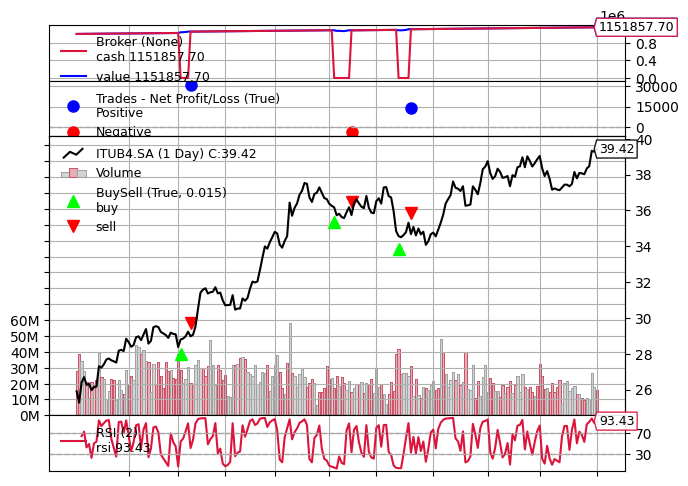

In [97]:
simulate_strategy(RSIMeanReversion)

PERFORMANCE METRICS SUMMARY
Total Return: 41.65%
Average Return: 0.1974%
Compound Annual Growth Rate: 6445.58%
Sharpe Ratio: 1.9026
Max Drawdown: 919.64%
Max Drawdown Duration: 59 periods
Max Drawdown Money: $133,323.70
Total Trades: 1
Total Open Trades: 0
Total Closed Trades: 1

Winning Trades: 1
Losing Trades: 0
Win Rate: 100.0%
Average Win: $515,617.90
Max Win: $515,617.90
Average Trade: $515,617.90
Average Trade Length: 209.0 periods
Final Portfolio Value: $1,516,694.93


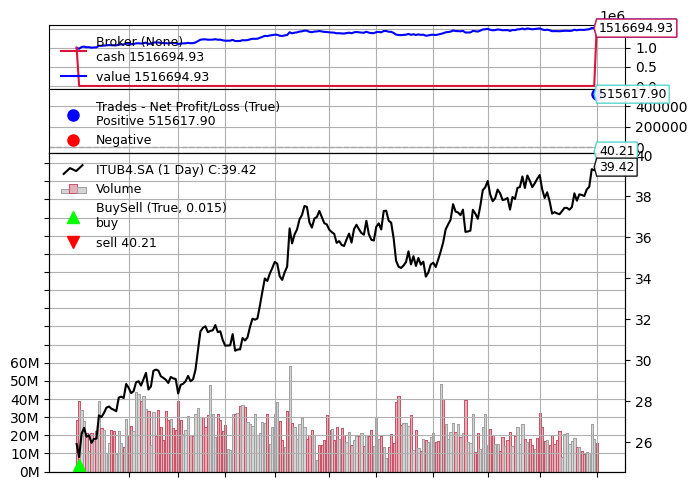

In [98]:
simulate_strategy(BuyAndHold)

PERFORMANCE METRICS SUMMARY
Total Return: 11.08%
Average Return: 0.0525%
Compound Annual Growth Rate: 1415.00%
Sharpe Ratio: N/A
Max Drawdown: 0.00%
Max Drawdown Duration: 0.0 periods
Max Drawdown Money: $0.00
Total Trades: 0
Final Portfolio Value: $1,117,183.92


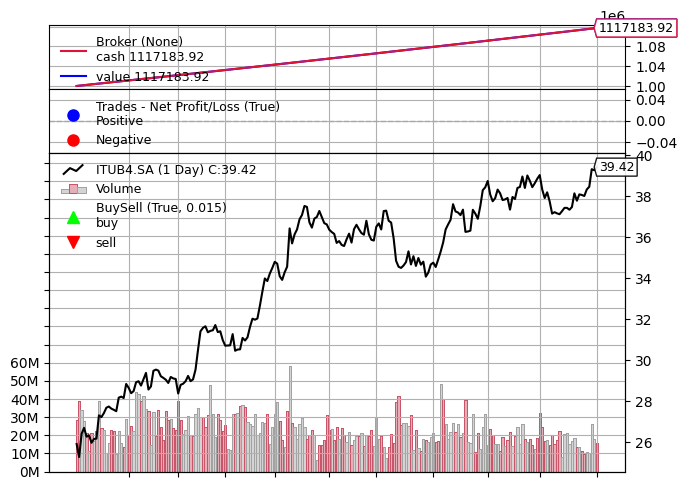

In [99]:
simulate_strategy(NeverBuy)